In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import statsmodels.api as sm
import numpy as np
from fredapi import Fred
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
fred = Fred(api_key='926acb260a284a87c73acdef0d2c2bd7')

## <span style = 'color:blue'> 1. Setting up Price data and market data

In [2]:
start_date = datetime(2016, 1, 1) 
end_date = datetime.now()
full_date_range = pd.date_range(start = start_date, end = end_date)

# Derive wmt price data
wmt = yf.download('WMT', start = start_date, end = end_date)
wmt.columns = wmt.columns.get_level_values(0)
wmt = wmt.reindex(full_date_range)

# Derive the US market data
market = yf.download('^GSPC', start = start_date, end = end_date)
market.columns = market.columns.get_level_values(0)
market = market.reindex(full_date_range)

print("wmt's data")
display(wmt)

print("market's data")
display(market)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

wmt's data


Price,Close,High,Low,Open,Volume
2016-01-01,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN
2016-01-04,17.109711,17.118063,16.803484,16.842459,35967600.0
2016-01-05,17.516153,17.552344,17.218279,17.268388,39978000.0
...,...,...,...,...,...
2025-10-16,106.470001,109.580002,105.660004,109.199997,16366200.0
2025-10-17,107.730003,108.199997,106.220001,107.169998,13708000.0
2025-10-18,NaN,NaN,NaN,NaN,NaN
2025-10-19,NaN,NaN,NaN,NaN,NaN


market's data


Price,Close,High,Low,Open,Volume
2016-01-01,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN
2016-01-04,2012.660034,2038.199951,1989.680054,2038.199951,4.304880e+09
2016-01-05,2016.709961,2021.939941,2004.170044,2013.780029,3.706620e+09
...,...,...,...,...,...
2025-10-16,6629.069824,6709.339844,6593.990234,6689.020020,6.048180e+09
2025-10-17,6664.009766,6678.879883,6603.759766,6613.270020,5.358120e+09
2025-10-18,NaN,NaN,NaN,NaN,NaN
2025-10-19,NaN,NaN,NaN,NaN,NaN


## <span style = 'color:blue'> 2. Setting up Macroeconomic Data

In [3]:
types = ['Unemployment', 'GDP', 'Interest', 'Housing', 'CPI', 'PPI', ]
series_id = ['UNRATE', 'GDP','DFF', 'CSUSHPINSA', 'CPIAUCSL', 'PPIACO']

for (type, id) in zip(types, series_id):
    globals()[f'{type}'] = fred.get_series(id).to_frame()
    globals()[f'{type}'].rename(columns = {0: type}, inplace = True)
    print(globals()[f'{type}'].head(2))

            Unemployment
1948-01-01           3.4
1948-02-01           3.8
            GDP
1946-01-01  NaN
1946-04-01  NaN
            Interest
1954-07-01      1.13
1954-07-02      1.25
            Housing
1975-01-01      NaN
1975-02-01      NaN
              CPI
1947-01-01  21.48
1947-02-01  21.62
             PPI
1913-01-01  12.1
1913-02-01  12.0


### <span style = 'color:red'> Calculate the inflation rate and Reallign the dates

In [4]:
adj_start_date = datetime(2016, 4, 1)
CPI_inflation = CPI.pct_change(12) # Year-over-year change
print(CPI_inflation.dropna().head(2))
CPI_inflation = CPI_inflation.loc[start_date:]

PPI_inflation = PPI.pct_change(12) # Year-over-year change
print(PPI_inflation.dropna().head(2))
PPI_inflation = PPI_inflation.loc[start_date:]

GDP_growth = GDP.pct_change(1) # Calculate quarterly growth rates
GDP_growth = (1 + GDP_growth)**(4)-1 # Annualize the growth rates 
print(GDP_growth.dropna().head(2))
GDP_growth =GDP_growth.loc[start_date:]

Interest = Interest.loc[adj_start_date:]

                 CPI
1948-01-01  0.102421
1948-02-01  0.094820
                 PPI
1914-01-01 -0.024793
1914-02-01 -0.016667
                 GDP
1947-04-01  0.046929
1947-07-01  0.060131


## <span style = 'color:blue'> 3. Setting up Financial Data

Text(0, 0.5, 'Close price ($)')

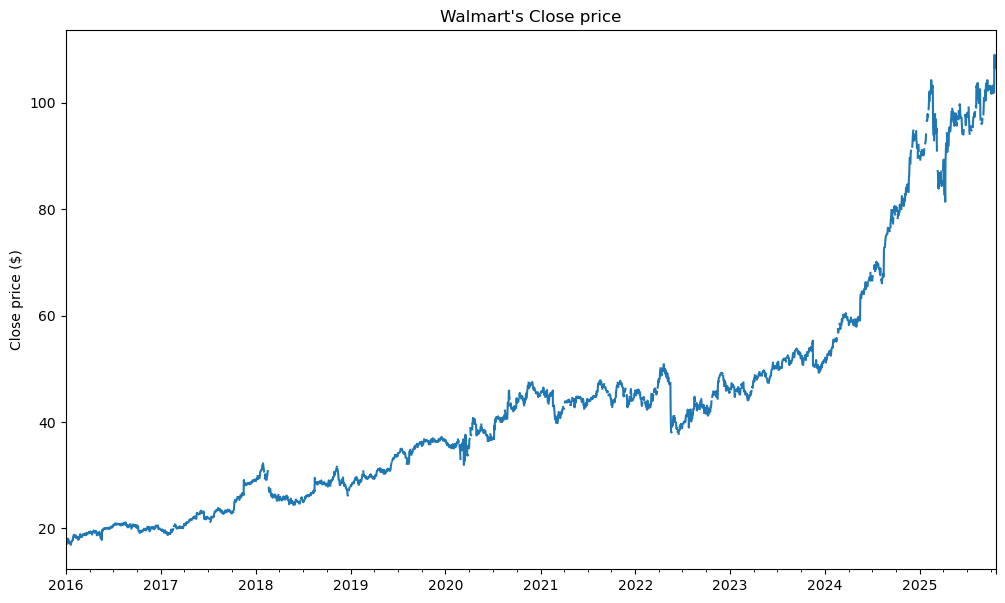

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (12, 7))
wmt.Close.plot(ax = ax)
ax.set_title("Walmart's Close price")
ax.set_xlabel('')
ax.set_ylabel('Close price ($)')

In [6]:
# ratios = pd.read_excel('Ratios.xlsx')
# ratios = ratios.T
# ratios.columns = ratios.iloc[0]
# ratios = ratios.iloc[1:]
# ratios.index = pd.to_datetime(ratios.index)
# ratios.loc[ratios['Incremental Operating Margin'] == '—', 'Incremental Operating Margin'] = np.nan
# ratios = ratios.dropna()
# ratios.to_csv('ratios_cleaned.csv')

In [7]:
ratios = pd.read_csv('ratios_cleaned.csv', index_col = 0)
ratios = ratios.dropna()
ratios.index = pd.to_datetime(ratios.index)
ratios

,Return on Common Equity,Return on Assets,Return on Capital,Return on Invested Capital,Gross Margin,EBITDA Margin,Operating Margin,Incremental Operating Margin,Pretax Margin,Income before XO Margin,Net Income Margin,Net Income to Common Margin,Effective Tax Rate,Dvd Payout Ratio,Sustainable Growth Rate
2015-10-31,19.01,7.31,12.76,12.90,25.52,6.88,4.87,-34.59,4.40,2.91,2.81,2.81,33.86,47.55,9.97
2016-01-31,18.15,7.29,12.61,12.49,25.19,7.00,5.12,-68.86,4.70,3.66,3.53,3.53,22.09,34.13,11.95
2016-07-31,18.96,7.43,13.32,13.38,25.96,7.18,5.10,15.36,4.63,3.22,3.12,3.12,30.54,41.35,11.12
2018-10-31,6.96,2.37,5.31,0.56,25.44,6.09,3.99,12.94,2.06,1.45,1.37,1.37,29.46,87.72,0.86
2019-01-31,8.87,3.15,6.55,0.95,24.41,6.34,4.37,63.34,4.08,2.75,2.66,2.66,32.68,40.82,5.25
2020-04-30,22.03,6.43,11.50,10.56,24.21,5.95,3.88,2.61,4.01,3.03,2.96,2.96,24.50,38.32,13.59
2020-07-31,24.57,7.58,13.24,10.72,25.45,6.41,4.40,6.46,6.28,4.67,4.70,4.70,25.53,23.61,18.77
2020-10-31,25.79,8.05,14.09,10.88,25.51,6.35,4.29,15.78,5.28,3.86,3.81,3.81,26.90,29.79,18.11
2021-04-30,16.72,5.22,9.24,10.59,25.33,6.92,5.00,45.69,2.78,2.03,1.97,1.97,26.87,56.74,7.23
2021-07-31,12.90,4.22,7.71,11.18,25.43,7.09,5.21,39.17,4.20,3.09,3.03,3.03,26.32,36.06,8.25


In [8]:
income = pd.read_excel("Income Statement.xlsx", index_col=0)
eps = income.loc['Diluted EPS, GAAP', :]
eps = eps.to_frame()
eps.columns = ['Diluted EPS']
eps

,Diluted EPS
2016-04-30,0.33
2016-07-31,0.4
2016-10-31,0.33
2017-01-31,0.41
2017-04-30,0.33
2017-07-31,0.32
2017-10-31,0.19
2018-01-31,0.24
2018-04-30,0.24
2018-07-31,-0.1


## <span style = 'color:blue'>4. Merge the data

In [9]:
# Readjust the start date so that the price data only includes non-null values
adj_start_date = datetime(2016, 4, 1)
df = pd.DataFrame({'Walmart': wmt['Close'],
                   'S&P500': market['Close']})
merge_data = [GDP_growth, CPI_inflation, PPI_inflation, Interest, ratios, eps]
for data in merge_data:
    df = df.merge(data, how = 'left', left_index = True, right_index = True)

df = df.ffill()
df = df.loc[adj_start_date:]
display(df)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21768\3711634284.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill()


,Walmart,S&P500,GDP,CPI,PPI,Interest,Return on Common Equity,Return on Assets,Return on Capital,Return on Invested Capital,...,Operating Margin,Incremental Operating Margin,Pretax Margin,Income before XO Margin,Net Income Margin,Net Income to Common Margin,Effective Tax Rate,Dvd Payout Ratio,Sustainable Growth Rate,Diluted EPS
2016-04-01,19.367783,2072.780029,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,12.49,...,5.12,-68.86,4.70,3.66,3.53,3.53,22.09,34.13,11.95,NaN
2016-04-02,19.367783,2072.780029,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,12.49,...,5.12,-68.86,4.70,3.66,3.53,3.53,22.09,34.13,11.95,NaN
2016-04-03,19.367783,2072.780029,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,12.49,...,5.12,-68.86,4.70,3.66,3.53,3.53,22.09,34.13,11.95,NaN
2016-04-04,19.379002,2066.129883,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,12.49,...,5.12,-68.86,4.70,3.66,3.53,3.53,22.09,34.13,11.95,NaN
2016-04-05,19.249994,2045.170044,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,12.49,...,5.12,-68.86,4.70,3.66,3.53,3.53,22.09,34.13,11.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-16,106.470001,6629.069824,0.060387,0.029392,0.027323,4.11,22.80,7.29,13.63,14.59,...,4.31,7.17,3.62,2.80,2.71,2.71,22.61,167.83,-15.46,0.88
2025-10-17,107.730003,6664.009766,0.060387,0.029392,0.027323,4.11,22.80,7.29,13.63,14.59,...,4.31,7.17,3.62,2.80,2.71,2.71,22.61,167.83,-15.46,0.88
2025-10-18,107.730003,6664.009766,0.060387,0.029392,0.027323,4.11,22.80,7.29,13.63,14.59,...,4.31,7.17,3.62,2.80,2.71,2.71,22.61,167.83,-15.46,0.88
2025-10-19,107.730003,6664.009766,0.060387,0.029392,0.027323,4.11,22.80,7.29,13.63,14.59,...,4.31,7.17,3.62,2.80,2.71,2.71,22.61,167.83,-15.46,0.88


## <span style = 'color:blue'>5. Calculate the technical indicators

In [10]:
import talib
df['MA30'] = talib.MA(df['Walmart'], 30)
df['MA7'] = talib.MA(df['Walmart'], 7)


lagged_df = df.drop(['Walmart', 'S&P500'], axis = 1).shift(1)
lagged_df['Walmart'] = df['Walmart']
lagged_df['S&P500'] = df['S&P500']
lagged_df.to_csv("final_data.csv")
display(lagged_df)

,GDP,CPI,PPI,Interest,Return on Common Equity,Return on Assets,Return on Capital,Return on Invested Capital,Gross Margin,EBITDA Margin,...,Net Income Margin,Net Income to Common Margin,Effective Tax Rate,Dvd Payout Ratio,Sustainable Growth Rate,Diluted EPS,MA30,MA7,Walmart,S&P500
2016-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.367783,2072.780029
2016-04-02,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,12.49,25.19,7.00,...,3.53,3.53,22.09,34.13,11.95,NaN,NaN,NaN,19.367783,2072.780029
2016-04-03,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,12.49,25.19,7.00,...,3.53,3.53,22.09,34.13,11.95,NaN,NaN,NaN,19.367783,2072.780029
2016-04-04,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,12.49,25.19,7.00,...,3.53,3.53,22.09,34.13,11.95,NaN,NaN,NaN,19.379002,2066.129883
2016-04-05,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,12.49,25.19,7.00,...,3.53,3.53,22.09,34.13,11.95,NaN,NaN,NaN,19.249994,2045.170044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-16,0.060387,0.029392,0.027323,4.10,22.80,7.29,13.63,14.59,24.94,6.34,...,2.71,2.71,22.61,167.83,-15.46,0.88,102.979333,103.664284,106.470001,6629.069824
2025-10-17,0.060387,0.029392,0.027323,4.11,22.80,7.29,13.63,14.59,24.94,6.34,...,2.71,2.71,22.61,167.83,-15.46,0.88,103.081000,104.335713,107.730003,6664.009766
2025-10-18,0.060387,0.029392,0.027323,4.11,22.80,7.29,13.63,14.59,24.94,6.34,...,2.71,2.71,22.61,167.83,-15.46,0.88,103.196333,105.177143,107.730003,6664.009766
2025-10-19,0.060387,0.029392,0.027323,4.11,22.80,7.29,13.63,14.59,24.94,6.34,...,2.71,2.71,22.61,167.83,-15.46,0.88,103.334000,106.018572,107.730003,6664.009766


In [11]:
# ...existing code...
df = pd.read_csv('final_data.csv', index_col = 0, parse_dates=True)
# ...existing code...

# <span style = 'color:orange'> Modelling

## <span style = 'color:blue'>1. Linear Regression (Strawman)


Number of components selected by PCA (retaining 95% variance): 3
Total explained variance by selected components: 0.9870

Linear Regression Model Summary (Trained on PCA-transformed Data before 2025-01-01):
                            OLS Regression Results                            
Dep. Variable:                Walmart   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.023e+05
Date:                Mon, 20 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:09:01   Log-Likelihood:                -5056.1
No. Observations:                2892   AIC:                         1.012e+04
Df Residuals:                    2888   BIC:                         1.014e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
  

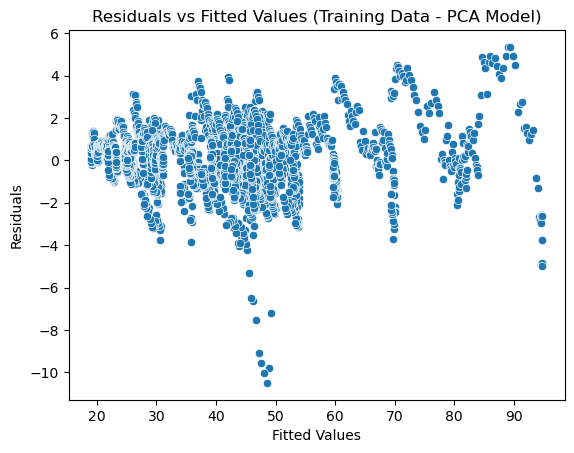

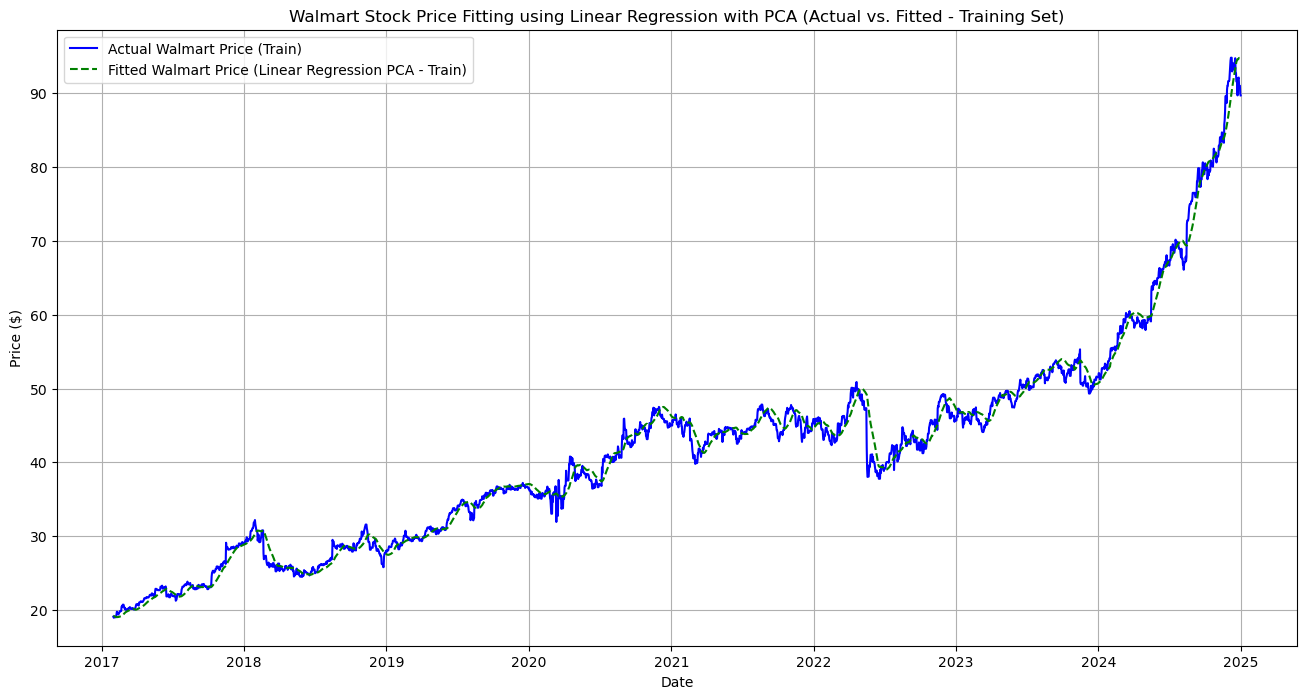

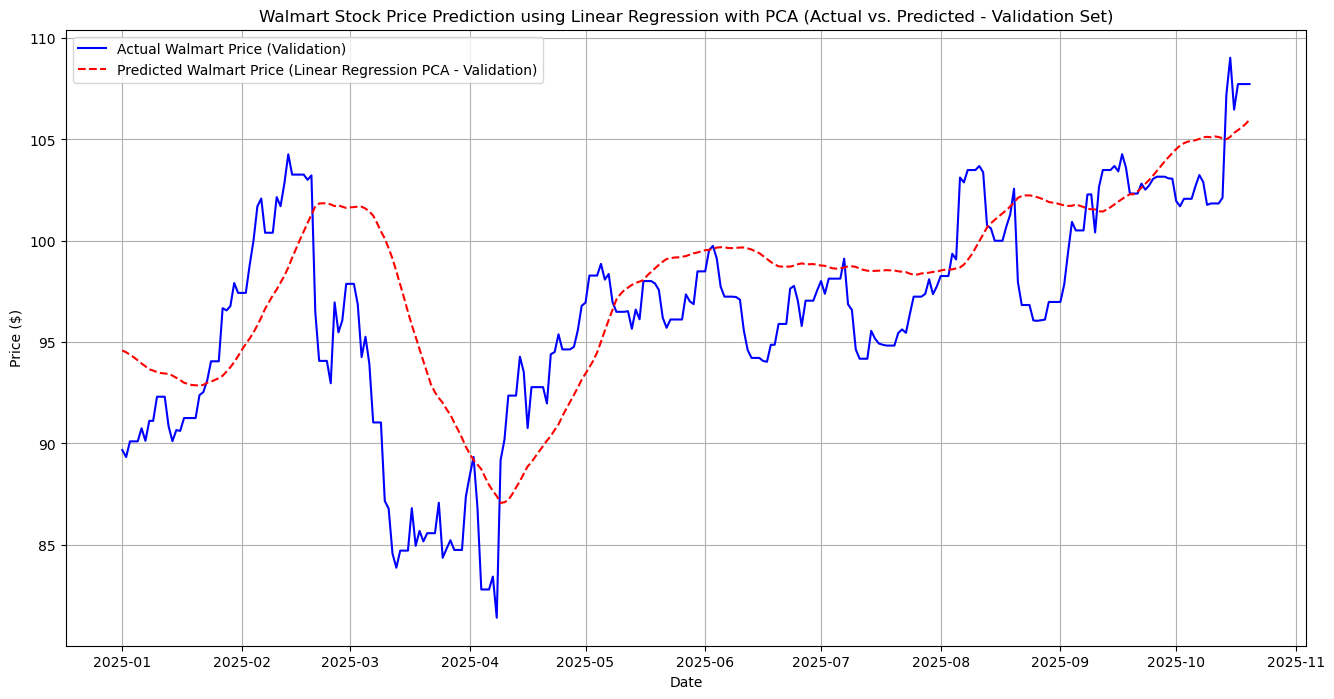

In [12]:
# ...existing code...
# Remove the single df['Walmart_Lag1'] line as it will be replaced by the loop below.
# df['Walmart_Lag1'] = df['Walmart'].shift(1)

# --- NEW: Create lagged features for daily data for the linear model ---
# We want to predict Walmart_t using data available up to t-1 (or t-30 for S&P500 and Walmart).
df = pd.read_csv('final_data.csv', index_col = 0, parse_dates=True)
df = df.loc['2017':]
df = df[['Walmart', 'S&P500', 'Net Income Margin', 'Diluted EPS', 'MA30', 'MA7']]

# Create 30 lagged S&P500 features
for i in range(1, 31):
    df[f'S&P500_Lag{i}'] = df['S&P500'].shift(i)

# Create 30 lagged Walmart features (the target itself)
for i in range(1, 31):
    df[f'Walmart_Lag{i}'] = df['Walmart'].shift(i)

# Create 1-day lagged features for MA30 and MA7 to avoid current-day leakage
df['MA30_Lag1'] = df['MA30'].shift(1)
df['MA7_Lag1'] = df['MA7'].shift(1)

# Drop any NaNs introduced by MA calculations and all new lagged features
df_model = df.dropna().copy()

import statsmodels.api as sm
import pandas as pd # Ensure pandas is imported for date handling
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from sklearn.decomposition import PCA # Import PCA

# Define the split date for linear regression (consistent with LSTM)
split_date_lr = pd.to_datetime('2025-01-01')

# Split the data into training and validation sets
df_train_lr = df_model[df_model.index < split_date_lr]
df_val_lr = df_model[df_model.index >= split_date_lr]

# Define features (X) and target (y) for training
y_train_lr = df_train_lr['Walmart']
y_val_lr = df_val_lr['Walmart'] # Also define y_val_lr here for consistency

# Define columns to exclude from features to prevent data leakage
# We exclude the current day's Walmart (target), S&P500, MA30, MA7
features_to_exclude_from_X = ['Walmart', 'S&P500', 'MA30', 'MA7']

# Build the raw feature sets for X_train_lr and X_val_lr
X_train_lr_raw = df_train_lr.drop(columns=features_to_exclude_from_X)
X_val_lr_raw = df_val_lr.drop(columns=features_to_exclude_from_X)

# --- Dimensionality Reduction using PCA ---

# 1. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lr_raw)
X_val_scaled = scaler.transform(X_val_lr_raw) # Use transform, not fit_transform for validation set

# Convert scaled arrays back to DataFrame for easier handling and column naming
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train_lr_raw.index, columns=X_train_lr_raw.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, index=X_val_lr_raw.index, columns=X_val_lr_raw.columns)


# 2. Apply PCA
pca = PCA(n_components=0.975) # Retain 97.5% of variance
X_train_pca = pca.fit_transform(X_train_scaled_df)
X_val_pca = pca.transform(X_val_scaled_df) # Use transform, not fit_transform for validation set

print(f"\nNumber of components selected by PCA (retaining 95% variance): {pca.n_components_}")
print(f"Total explained variance by selected components: {pca.explained_variance_ratio_.sum():.4f}")

# Convert PCA components back to DataFrame for OLS and adding constant
X_train_lr_pca = pd.DataFrame(X_train_pca, index=df_train_lr.index,
                              columns=[f'PC{i+1}' for i in range(pca.n_components_)])
X_val_lr_pca = pd.DataFrame(X_val_pca, index=df_val_lr.index,
                            columns=[f'PC{i+1}' for i in range(pca.n_components_)])


# 3. Add a constant to the independent variables (PCA components)
X_train_lr_final = sm.add_constant(X_train_lr_pca)
X_val_lr_final = sm.add_constant(X_val_lr_pca)

# Create and fit the OLS model on the PCA-transformed training data
model_lr = sm.OLS(y_train_lr, X_train_lr_final)
results_lr = model_lr.fit()

# Print the summary of the regression results for the training model
print("\nLinear Regression Model Summary (Trained on PCA-transformed Data before 2025-01-01):")
print(results_lr.summary())

# Get fitted values for the training set
fitted_values_train_lr = results_lr.fittedvalues
residuals_train_lr = results_lr.resid
print("\nResiduals for Training Data (PCA Model):")
sns.scatterplot(x = fitted_values_train_lr, y = residuals_train_lr)
plt.title('Residuals vs Fitted Values (Training Data - PCA Model)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


# Make predictions on the validation set using the PCA-transformed features
predictions_val_lr = results_lr.predict(X_val_lr_final)

# Plotting the fitted values against the actual values for the Training Set
plt.figure(figsize=(16, 8))
plt.plot(y_train_lr.index, y_train_lr, label='Actual Walmart Price (Train)', color='blue')
plt.plot(y_train_lr.index, fitted_values_train_lr, label='Fitted Walmart Price (Linear Regression PCA - Train)', color='green', linestyle='--')
plt.title('Walmart Stock Price Fitting using Linear Regression with PCA (Actual vs. Fitted - Training Set)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the predicted values against the actual values for the Validation Set
plt.figure(figsize=(16, 8))
plt.plot(y_val_lr.index, y_val_lr, label='Actual Walmart Price (Validation)', color='blue')
plt.plot(y_val_lr.index, predictions_val_lr, label='Predicted Walmart Price (Linear Regression PCA - Validation)', color='red', linestyle='--')
plt.title('Walmart Stock Price Prediction using Linear Regression with PCA (Actual vs. Predicted - Validation Set)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

## <span style = 'color:blue'> 2.LSTM Model

In [13]:
# # ...existing code...
# import numpy as np
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler # Changed from MinMaxScaler to StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization # Import BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Import callbacks
# import matplotlib.pyplot as plt
# import pickle # Import pickle for saving scalers
# import pandas as pd # Ensure pandas is imported for date handling

# df = pd.read_csv('final_data.csv', index_col = 0, parse_dates=True)
# df = df.loc['2017 ':]
# df = df[['Walmart', 'S&P500', 'Diluted EPS', 'MA30', 'MA7']]
# # Let's explicitly add the desired lags for the LSTM model here.
# # Create 5 lagged Walmart features (the target itself) from the current 'Walmart' column in df
# for i in range(1, 1): # FIXED: Lags 1 to 5
#     df[f'Walmart_Lag{i}'] = df['Walmart'].shift(i)

# # Create 5 lagged S&P500 features from the current 'S&P500' column in df
# for i in range(1, 1): # FIXED: Lags 1 to 5
#     df[f'S&P500_Lag{i}'] = df['S&P500'].shift(i)

# # Prepare the data for LSTM
# # Drop rows with NaN values, which might be introduced by new lagged features
# df_lstm = df.dropna().copy()

# # Define features (X) and target (y)
# # The target is the 'Walmart' close price
# # Features are all other columns, EXCLUDING current-day 'Walmart' (target) and 'S&P500'.
# # Other columns like 'MA30', 'MA7', 'ATR', and macro/ratios are already lagged by 1 day in df_lstm,
# # so they are valid features and should NOT be excluded.
# features_to_exclude_from_X_lstm = ['Walmart', 'S&P500']
# X_data = df_lstm.drop(columns=features_to_exclude_from_X_lstm).values
# y_data = df_lstm['Walmart'].values.reshape(-1, 1) # Reshape for scaler


# # Scale the features and target
# scaler_X = StandardScaler()
# X_scaled = scaler_X.fit_transform(X_data)

# scaler_y = StandardScaler()
# y_scaled = scaler_y.fit_transform(y_data)

# # Define the number of time steps (look-back window)
# n_steps = 7

# # Create sequences for LSTM
# def create_sequences(X, y, n_steps):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - n_steps):
#         X_seq.append(X[i:(i + n_steps), :])
#         y_seq.append(y[i + n_steps, 0]) # Predict the next day's price (y_t using X_{t-n_steps} to X_{t-1})
#     return np.array(X_seq), np.array(y_seq)

# X_seq, y_seq = create_sequences(X_scaled, y_scaled, n_steps)

# # --- NEW: Date-based splitting for training and test/validation sets ---
# # Get the corresponding dates for the sequences.
# # y_seq[k] predicts the price for df_lstm.index[k + n_steps].
# sequence_dates = df_lstm.index[n_steps:]

# # Define the split dates for the test/validation set
# val_start_date = pd.to_datetime('2025-01-01')
# val_end_date = datetime.now()

# # Create masks for splitting
# train_mask = sequence_dates < val_start_date
# test_mask = (sequence_dates >= val_start_date) & (sequence_dates <= val_end_date)

# # Split data into training and testing sets based on dates
# X_train = X_seq[train_mask]
# y_train = y_seq[train_mask]

# X_test = X_seq[test_mask]
# y_test = y_seq[test_mask]

# # Print sizes to confirm split
# print(f"Training set size: {len(X_train)} sequences")
# print(f"Test/Validation set size (from {val_start_date.strftime('%Y-%m-%d')} to {val_end_date.strftime('%Y-%m-%d')}): {len(X_test)} sequences")

# # Build the LSTM model
# model = Sequential()
# # First LSTM layer with increased units, returns sequences for the next LSTM layer
# model.add(LSTM(512, return_sequences=True, input_shape=(n_steps, X_seq.shape[2]))) 
# model.add(Dropout(0.2)) 

# # Second LSTM layer with increased units, returns sequences
# model.add(LSTM(256, return_sequences=True)) 

# model.add(Dropout(0.2))
# model.add(LSTM(128)) 

# model.add(Dropout(0.2))
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) # Added RMSE metric

# # Print model summary
# print(model.summary())

# # Define callbacks for early stopping and model checkpointing
# model_filepath = 'best_lstm_model.keras' # .keras is the recommended extension for Keras models
# checkpoint = ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1, restore_best_weights=True) # Increased patience slightly

# # Train the model
# print("\nTraining the LSTM model...")
# history = model.fit(X_train, y_train,
#                     epochs=150,
#                     batch_size = 100, 
#                     validation_split=0.1, 
#                     verbose=1,
#                     callbacks=[checkpoint, early_stopping]) 

# # Load the best model saved by the checkpoint for evaluation and prediction
# best_model = tf.keras.models.load_model(model_filepath)

# # Evaluate the best model on the specified test/validation set
# loss = best_model.evaluate(X_test, y_test, verbose=0)
# print(f'\nTest/Validation Loss (Mean Squared Error) from best model: {loss[0]:.4f}')

# # Make predictions using the best model on the test/validation set
# y_pred_scaled = best_model.predict(X_test)

# # Inverse transform the predictions and actual values to original scale
# y_pred = scaler_y.inverse_transform(y_pred_scaled)
# y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# # Plot the results (Actual vs. Predicted for Test/Validation Set)
# plt.figure(figsize=(16, 8))
# # Use the actual dates for the x-axis for better readability
# test_dates_plot = sequence_dates[test_mask] # Use a different variable name to avoid confusion with loaded part
# plt.plot(test_dates_plot, y_test_actual, label='Actual Walmart Price (Test/Validation)', color='blue')
# plt.plot(test_dates_plot, y_pred, label='Predicted Walmart Price (Test/Validation)', color='red', linestyle='--')
# plt.title('Walmart Stock Price Prediction using LSTM (Actual vs. Predicted - Test/Validation Set)')
# plt.xlabel('Date')
# plt.ylabel('Price ($)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Make predictions on the training set
# y_train_pred_scaled = best_model.predict(X_train)

# # Inverse transform the training predictions and actual training values
# y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
# y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# # Plot the results (Fitted vs. Actual for Training Set)
# plt.figure(figsize=(16, 8))
# train_dates_plot = sequence_dates[train_mask] # Use a different variable name
# plt.plot(train_dates_plot, y_train_actual, label='Actual Walmart Price (Train)', color='green')
# plt.plot(train_dates_plot, y_train_pred, label='Fitted Walmart Price (Train)', color='orange', linestyle='--')
# plt.title('Walmart Stock Price Fitting using LSTM (Actual vs. Fitted - Training Set)')
# plt.xlabel('Date')
# plt.ylabel('Price ($)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss Over Epochs')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.show()

# # Save the scalers using pickle
# with open('scaler_X.pkl', 'wb') as f:
#     pickle.dump(scaler_X, f)
# with open('scaler_y.pkl', 'wb') as f:
#     pickle.dump(scaler_y, f)
# print(f"\nScalers saved to 'scaler_X.pkl' and 'scaler_y.pkl'")

# # Save the preprocessed sequence data
# # We save X_seq, y_seq, sequence_dates (as values), train_mask, and test_mask
# np.savez('lstm_preprocessed_data.npz',
#          X_seq=X_seq,
#          y_seq=y_seq,
#          sequence_dates_values=sequence_dates.values,
#          train_mask=train_mask,
#          test_mask=test_mask)
# print(f"Preprocessed LSTM data saved to 'lstm_preprocessed_data.npz'")
# # ...existing code...

--- Loading Trained LSTM Model and Preprocessed Data ---
LSTM model loaded successfully from 'best_lstm_model.keras'
Scalers loaded successfully from 'scaler_X.pkl' and 'scaler_y.pkl'
Preprocessed LSTM data loaded successfully from 'lstm_preprocessed_data.npz'
Loaded Training set size: 2915 sequences
Loaded Test/Validation set size: 293 sequences
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Test/Validation RMSE from loaded model: 3.0120


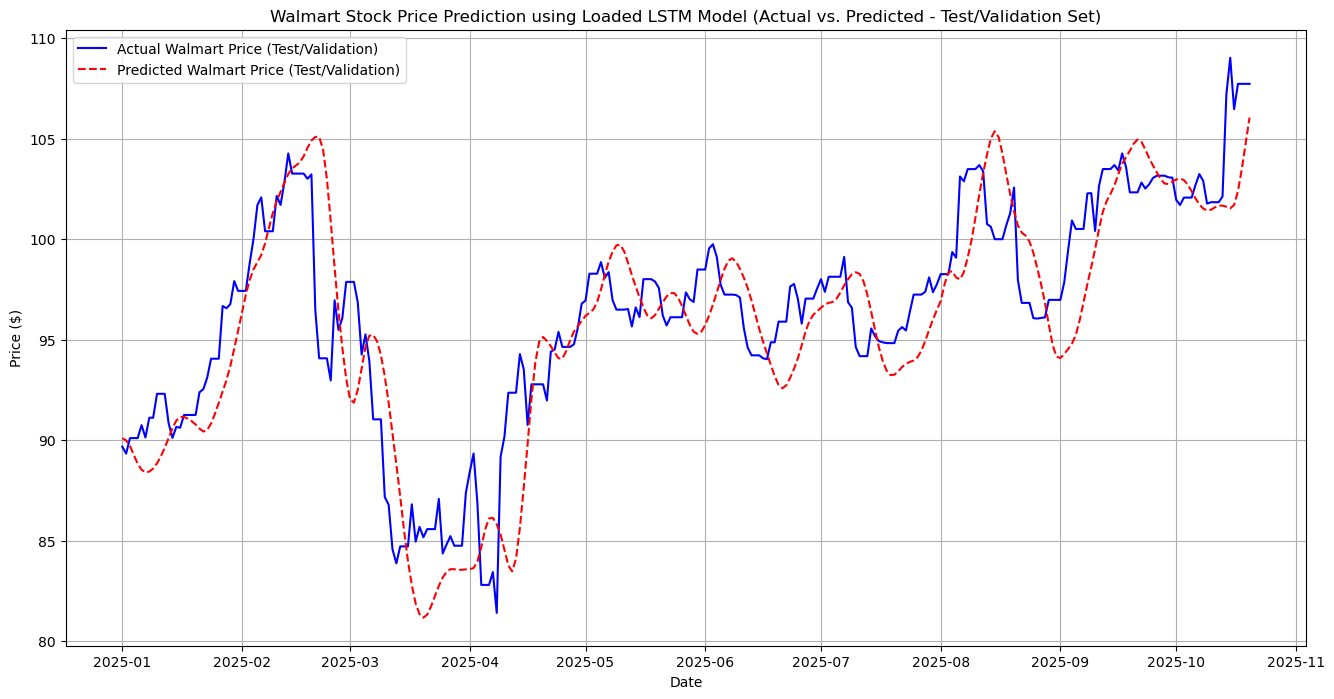

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


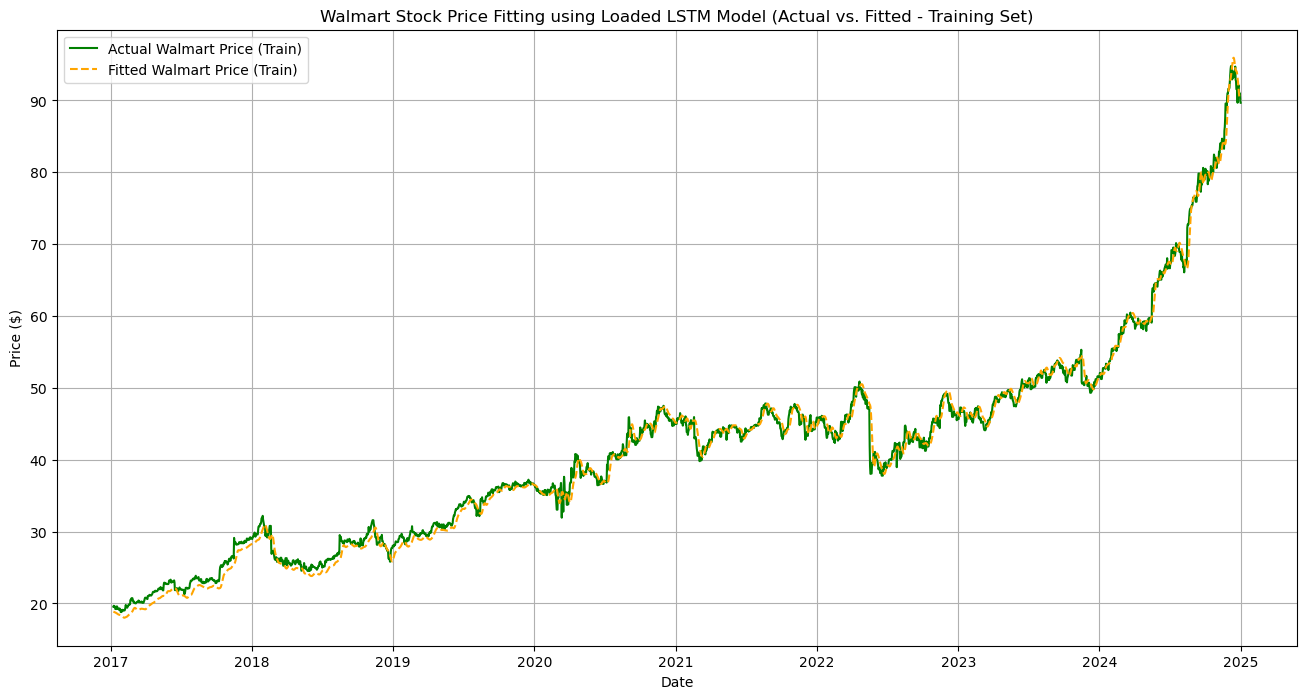


--- Loaded Model Prediction Complete ---


In [14]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import datetime # Needed for val_end_date if not loaded

print("--- Loading Trained LSTM Model and Preprocessed Data ---")

# 1. Load the trained model
try:
    best_model = tf.keras.models.load_model('best_lstm_model.keras')
    print("LSTM model loaded successfully from 'best_lstm_model.keras'")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the training part has been run and 'best_lstm_model.keras' exists.")
    # Exit or handle error appropriately if model cannot be loaded
    exit()

# 2. Load the scalers
try:
    with open('scaler_X.pkl', 'rb') as f:
        scaler_X = pickle.load(f)
    with open('scaler_y.pkl', 'rb') as f:
        scaler_y = pickle.load(f)
    print("Scalers loaded successfully from 'scaler_X.pkl' and 'scaler_y.pkl'")
except Exception as e:
    print(f"Error loading scalers: {e}")
    print("Please ensure the training part has been run and scaler files exist.")
    exit()

# 3. Load the preprocessed sequence data
try:
    loaded_data = np.load('lstm_preprocessed_data.npz', allow_pickle=True)
    X_seq = loaded_data['X_seq']
    y_seq = loaded_data['y_seq']
    sequence_dates = pd.to_datetime(loaded_data['sequence_dates_values'])
    train_mask = loaded_data['train_mask']
    test_mask = loaded_data['test_mask']
    print("Preprocessed LSTM data loaded successfully from 'lstm_preprocessed_data.npz'")
except Exception as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please ensure the training part has been run and 'lstm_preprocessed_data.npz' exists.")
    exit()

# Re-create X_train, y_train, X_test, y_test from loaded sequences and masks
X_train = X_seq[train_mask]
y_train = y_seq[train_mask]
X_test = X_seq[test_mask]
y_test = y_seq[test_mask]

print(f"Loaded Training set size: {len(X_train)} sequences")
print(f"Loaded Test/Validation set size: {len(X_test)} sequences")

# --- Make predictions and evaluate ---

# Evaluate the loaded model on the test/validation set
# Note: The model.evaluate method expects the same metrics as compiled with.
# If you want RMSE, ensure it was compiled with it.
# For simplicity, we'll just calculate MSE and RMSE manually from predictions.
# loss = best_model.evaluate(X_test, y_test, verbose=0)
# print(f'\nTest/Validation Loss (Mean Squared Error) from loaded model: {loss[0]:.4f}')

# Make predictions on the test set
y_pred_scaled = best_model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for the test set
from sklearn.metrics import mean_squared_error
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f"\nTest/Validation RMSE from loaded model: {rmse_test:.4f}")

# Plot the results (Actual vs. Predicted for Test/Validation Set)
plt.figure(figsize=(16, 8))
test_dates_plot = sequence_dates[test_mask]
plt.plot(test_dates_plot, y_test_actual, label='Actual Walmart Price (Test/Validation)', color='blue')
plt.plot(test_dates_plot, y_pred, label='Predicted Walmart Price (Test/Validation)', color='red', linestyle='--')
plt.title('Walmart Stock Price Prediction using Loaded LSTM Model (Actual vs. Predicted - Test/Validation Set)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions on the training set (fitted values)
y_train_pred_scaled = best_model.predict(X_train)

# Inverse transform the training predictions and actual training values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# Plot the results (Fitted vs. Actual for Training Set)
plt.figure(figsize=(16, 8))
train_dates_plot = sequence_dates[train_mask]
plt.plot(train_dates_plot, y_train_actual, label='Actual Walmart Price (Train)', color='green')
plt.plot(train_dates_plot, y_train_pred, label='Fitted Walmart Price (Train)', color='orange', linestyle='--')
plt.title('Walmart Stock Price Fitting using Loaded LSTM Model (Actual vs. Fitted - Training Set)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Loaded Model Prediction Complete ---")

## <span style = 'color:blue'> 3. XGBoost Model

In [15]:
# import pandas as pd
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np
# import optuna # Import Optuna
# import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting

# # filepath: d:\Visual Studio Projects\BWIN\final_data.csv
# df = pd.read_csv('d:/Visual Studio Projects/BWIN/final_data.csv', index_col=0, parse_dates=True)
# df = df.loc['2017 ':]
# df = df[['Walmart', 'S&P500', 'Diluted EPS', 'MA30', 'MA7']]

# # Define target variable
# y = df['Walmart']

# # Add lagged features for Walmart (1 to 30)
# for i in range(1, 25):
#     df[f'Walmart_Lag{i}'] = df['Walmart'].shift(i)

# # Add lagged features for S&P500 (1 to 30)
# for i in range(1, 25):
#     df[f'S&P500_Lag{i}'] = df['S&P500'].shift(i)

# # Add lag 1 for technical indicators MA30 and MA7 to avoid data leakage
# df['MA30_Lag1'] = df['MA30'].shift(1)
# df['MA7_Lag1'] = df['MA7'].shift(1)

# # Define features (excluding current day's target, original MA30, MA7, and S&P500 to avoid leakage)
# X = df.drop(columns=['Walmart', 'S&P500', 'MA30', 'MA7'])

# # Handle any remaining missing values in features (e.g., forward fill then backward fill)
# X = X.fillna(method='ffill')
# X = X.fillna(method='bfill')

# # Align X and y after handling NaNs, dropping rows where y might be NaN
# df_aligned = pd.concat([X, y], axis=1).dropna()
# X = df_aligned.drop(columns=['Walmart'])
# y = df_aligned['Walmart']

# # Time-series split: Use an earlier portion for training and a later portion for testing.
# # For example, use the first 80% of the data for training and the last 20% for testing.
# train_size = int(len(X) * 0.8)
# X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # --- Optuna Hyperparameter Tuning for XGBoost ---

# def objective(trial):
#     """
#     Objective function for Optuna to optimize XGBoost hyperparameters.
#     It returns the Root Mean Squared Error (RMSE) on the test set.
#     """
#     param = {
#         'objective': 'reg:squarederror',
#         'eval_metric': 'rmse', # Evaluate using RMSE
#         'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 0.5),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5), # L1 regularization
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 1.5), # L2 regularization
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'random_state': 42,
#         'n_jobs': -1 # Use all available cores
#     }

#     model = xgb.XGBRegressor(**param)
    
#     # Use early stopping during tuning to speed up the process and prevent overfitting
#     model.fit(X_train, y_train,
#               eval_set=[(X_test, y_test)],
#               verbose=False) # Suppress verbose output during tuning

#     y_pred = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     return rmse

# print("Starting Optuna hyperparameter tuning...")
# # Create an Optuna study and optimize the objective function
# # 'minimize' direction because we want to minimize RMSE
# # Use a fixed seed for the sampler for reproducibility of the study itself
# study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=100, show_progress_bar=True) # Run 100 trials (can be adjusted)

# print("\nOptuna tuning finished.")
# print(f"Number of finished trials: {len(study.trials)}")
# print(f"Best trial RMSE: {study.best_trial.value:.4f}")
# print("Best hyperparameters found:")
# best_params = study.best_trial.params
# for key, value in best_params.items():
#     print(f"  {key}: {value}")

# # Initialize and train the final XGBoost Regressor model with the best hyperparameters
# print("\nTraining final model with best hyperparameters...")
# final_model = xgb.XGBRegressor(objective='reg:squarederror',
#                                **best_params,
#                                random_state=42,
#                                n_jobs=-1) # Use all available cores

# final_model.fit(X_train, y_train)

# # Save the best model
# model_filepath = 'best_xgboost_model.json'
# final_model.save_model(model_filepath)
# print(f"Best XGBoost model saved to '{model_filepath}'")

# # Make predictions on the test set using the final model
# y_pred = final_model.predict(X_test)

# # Evaluate the final model
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print(f"\nFinal Model Evaluation:")
# print(f"Mean Squared Error (MSE): {mse:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"R-squared (R2): {r2:.4f}")

# # Visualize the predictions
# plt.figure(figsize=(12, 6))
# plt.plot(y_test.index, y_test, label='Actual Walmart Price')
# plt.plot(y_test.index, y_pred, label='Predicted Walmart Price')
# plt.title('Walmart Stock Price Prediction with XGBoost (Tuned with Optuna)')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.show()

In [16]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error, r2_score
# from datetime import datetime
# # ...existing code...

# # Load the preprocessed data
# df = pd.read_csv('final_data.csv', index_col=0, parse_dates=True)

# # Define the target variable
# y = df['Walmart']

# # Define exogenous variables (X)
# # Exclude 'Walmart' (target) and 'S&P500' (current day's market data, which would be data leakage)
# # All other columns in 'final_data.csv' are already lagged by one day due to previous processing.
# exog_cols = df.columns.drop(['Walmart', 'S&P500'])
# X = df[exog_cols]

# # Define the split date for consistency with other models
# split_date_sarima = pd.to_datetime('2025-01-01')

# # Split the data into training and validation sets
# y_train_sarima = y[y.index < split_date_sarima]
# y_val_sarima = y[y.index >= split_date_sarima]

# X_train_sarima = X[X.index < split_date_sarima]
# X_val_sarima = X[X.index >= split_date_sarima]

# # Ensure X_train_sarima and X_val_sarima are aligned with y_train_sarima and y_val_sarima
# # This is crucial for SARIMAX with exogenous variables.
# # Drop any rows with NaNs that might have resulted from the split or initial data.
# # Note: SARIMAX handles NaNs in exog by dropping corresponding rows, so it's good to align first.
# combined_train = pd.concat([y_train_sarima, X_train_sarima], axis=1).dropna()
# y_train_sarima = combined_train['Walmart']
# X_train_sarima = combined_train.drop(columns=['Walmart'])

# combined_val = pd.concat([y_val_sarima, X_val_sarima], axis=1).dropna()
# y_val_sarima = combined_val['Walmart']
# X_val_sarima = combined_val.drop(columns=['Walmart'])


# # --- SARIMA Model Implementation ---
# # Choosing SARIMA orders (p, d, q) and seasonal orders (P, D, Q, S) is crucial.
# # (p, d, q): non-seasonal orders (AR, I, MA)
# # (P, D, Q, S): seasonal orders (Seasonal AR, Seasonal I, Seasonal MA, Seasonal period)

# # A common starting point for 'd' (differencing order) is 1 for financial time series
# # to achieve stationarity. 'p' and 'q' can be explored using ACF/PACF plots.
# # For demonstration, let's use a simple ARIMA(5,1,0) model (ARIMA is SARIMA with S=0).
# # We'll keep seasonal_order as (0,0,0,0) for now, as strong daily seasonality is less common.

# order = (5, 1, 0) # p=5 (AR terms), d=1 (differencing), q=0 (MA terms)
# seasonal_order = (1, 5, 0, 7) # P, D, Q, S (S=0 for non-seasonal)

# print(f"\nFitting SARIMA model with order={order}, seasonal_order={seasonal_order}, and exogenous variables...")

# # Fit the SARIMA model with exogenous variables
# model_sarima = SARIMAX(y_train_sarima, exog=X_train_sarima, order=order, seasonal_order=seasonal_order,
#                        enforce_stationarity=False, # Set to False for initial exploration, but ideally True
#                        enforce_invertibility=False) # Set to False for initial exploration, but ideally True

# results_sarima = model_sarima.fit(disp=False) # disp=False suppresses convergence output

# print("\nSARIMA Model Summary (Trained on Data before 2025-01-01 with Exogenous Variables):")
# print(results_sarima.summary())

# # Make predictions on the training set
# # When using exog, you must provide exog for prediction as well.
# fitted_values_train_sarima = results_sarima.predict(start=y_train_sarima.index[0], end=y_train_sarima.index[-1], exog=X_train_sarima)

# # Make predictions on the validation set
# # The 'start' and 'end' dates should correspond to the validation set's index.
# predictions_val_sarima = results_sarima.predict(start=y_val_sarima.index[0], end=y_val_sarima.index[-1], exog=X_val_sarima)

# # --- Evaluate the model ---
# mse_sarima = mean_squared_error(y_val_sarima, predictions_val_sarima)
# rmse_sarima = np.sqrt(mse_sarima)
# r2_sarima = r2_score(y_val_sarima, predictions_val_sarima)

# print(f"\nSARIMA Model Evaluation on Validation Set (from {split_date_sarima}):")
# print(f"Mean Squared Error (MSE): {mse_sarima:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse_sarima:.4f}")
# print(f"R-squared (R2): {r2_sarima:.4f}")

# # --- Visualize the predictions ---
# plt.figure(figsize=(16, 8))
# plt.plot(y_train_sarima.index, y_train_sarima, label='Actual Walmart Price (Train)', color='blue')
# plt.plot(y_train_sarima.index, fitted_values_train_sarima, label='Fitted Walmart Price (SARIMA - Train)', color='green', linestyle='--')
# plt.plot(y_val_sarima.index, y_val_sarima, label='Actual Walmart Price (Validation)', color='orange')
# plt.plot(y_val_sarima.index, predictions_val_sarima, label='Predicted Walmart Price (SARIMA - Validation)', color='red', linestyle='--')
# plt.title(f'Walmart Stock Price Prediction using SARIMAX (Order={order}, Seasonal Order={seasonal_order}) with Exog')
# plt.xlabel('Date')
# plt.ylabel('Price ($)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # --- Further Steps for SARIMA ---
# # 1.  **Determine (p, d, q) and (P, D, Q, S) orders:**
# #     *   Use ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots of the differenced series to identify p, q, P, Q.
# #     *   Use statistical tests like the Augmented Dickey-Fuller (ADF) test to determine the differencing order 'd' and seasonal differencing 'D' to achieve stationarity.
# #     *   The seasonal period 'S' is typically known (e.g., 7 for daily, 12 for monthly).
# #     *   Libraries like `pmdarima` (auto_arima) can automate this process.
# # 2.  **Include Exogenous Variables:** If you believe macroeconomic data or financial ratios have a direct, linear impact on the target, you can include them as `exog` variables. Ensure they are properly lagged to avoid data leakage.
# # 3.  **Cross-Validation:** For more robust evaluation, consider time series cross-validation techniques.

## <span style = 'color:blue'> 4. Support Vector Regression

C:\Users\nguye\AppData\Local\Temp\ipykernel_30076\3533045501.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_Lag{i}'] = df[col].shift(i)
[I 2025-11-12 15:16:04,469] A new study created in memory with name: no-name-f7a3d1d8-284b-4d84-b13a-c76ff31839a4


--- SVR Model Implementation ---

Starting Optuna hyperparameter tuning for SVR...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-12 15:17:41,405] Trial 0 finished with value: 1.2530297008941635 and parameters: {'kernel': 'linear', 'C': 24.81040974867808, 'epsilon': 0.020513382630874502, 'gamma': 'scale'}. Best is trial 0 with value: 1.2530297008941635.
[I 2025-11-12 15:17:41,667] Trial 1 finished with value: 41.82323380648589 and parameters: {'kernel': 'rbf', 'C': 0.12087541473056956, 'epsilon': 0.8706020878304853, 'gamma': 'scale'}. Best is trial 0 with value: 1.2530297008941635.
[I 2025-11-12 15:17:41,667] Trial 1 finished with value: 41.82323380648589 and parameters: {'kernel': 'rbf', 'C': 0.12087541473056956, 'epsilon': 0.8706020878304853, 'gamma': 'scale'}. Best is trial 0 with value: 1.2530297008941635.
[I 2025-11-12 15:17:42,873] Trial 2 finished with value: 42.78025860486168 and parameters: {'kernel': 'poly', 'C': 12.561043700013547, 'epsilon': 0.0730953983591291, 'degree': 3, 'gamma': 'scale'}. Best is trial 0 with value: 1.2530297008941635.
[I 2025-11-12 15:17:42,873] Trial 2 finished with v

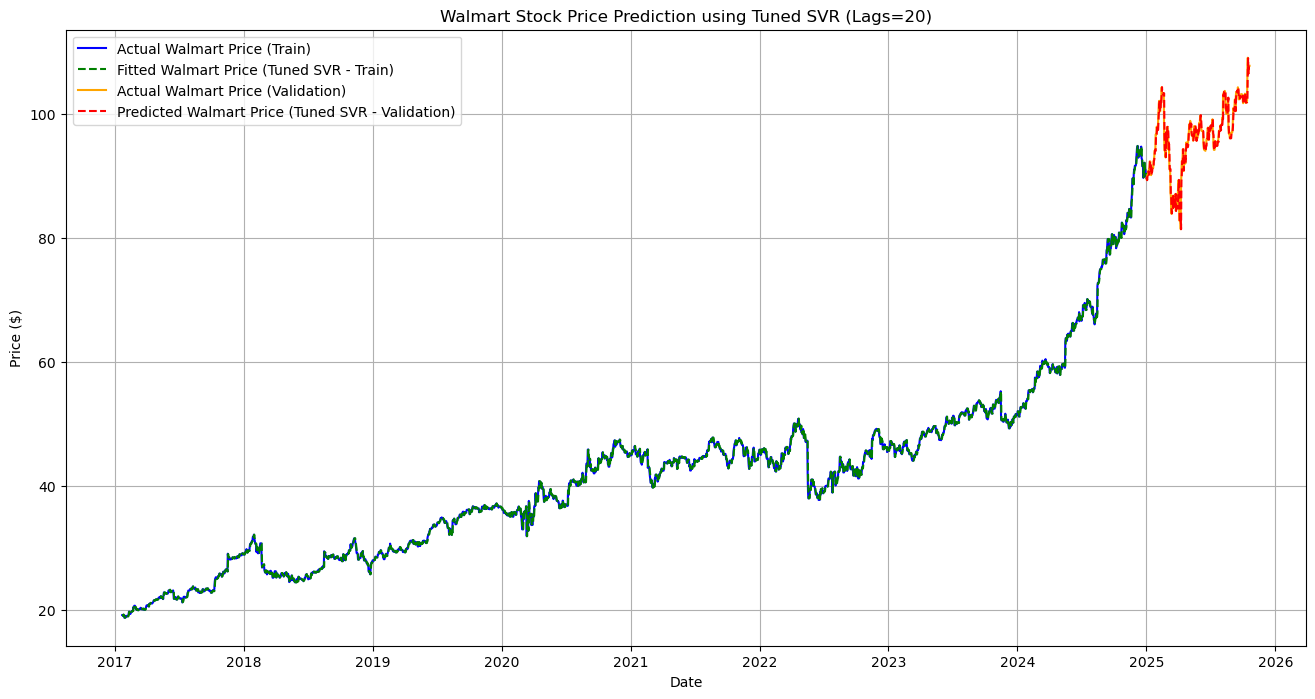


--- Tuned SVR Model Complete ---


In [3]:
# ...existing code...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import optuna
import joblib
import pickle # Import pickle for saving the Optuna study

print("--- SVR Model Implementation ---")

# Load the preprocessed data
df = pd.read_csv('final_data.csv', index_col = 0, parse_dates=True)
df = df.loc['2017 ':]
df = df[['Walmart', 'S&P500', 'Diluted EPS', 'MA30', 'MA7']]

# --- Prepare data for SVR ---
# SVR requires features (X) and a target (y).
# We will create lagged features from the existing columns.
n_lags = 20 # Define the number of lags to use for features

# Create lagged features for all relevant columns
for col in ['Walmart', 'S&P500', 'Diluted EPS', 'MA30', 'MA7']:
    for i in range(1, n_lags + 1):
        df[f'{col}_Lag{i}'] = df[col].shift(i)

# Drop rows with NaN values introduced by lagging
df_svr = df.dropna().copy()

# Define the target variable (current day's Walmart price)
y_svr = df_svr['Walmart']

# Define features (all lagged columns)
# Exclude the current day's 'Walmart', 'S&P500', 'Diluted EPS', 'MA30', 'MA7' from features
# as they represent current or future information relative to the target.
features_to_exclude_from_X = ['Walmart', 'S&P500', 'Diluted EPS', 'MA30', 'MA7']
X_svr = df_svr.drop(columns=features_to_exclude_from_X)

# Define the split date for consistency with other models
split_date_svr = pd.to_datetime('2025-01-01')

# Split the data into training and validation sets
X_train_svr = X_svr[X_svr.index < split_date_svr]
y_train_svr = y_svr[y_svr.index < split_date_svr]

X_val_svr = X_svr[X_svr.index >= split_date_svr]
y_val_svr = y_svr[y_svr.index >= split_date_svr]

# Scale the features (X) for SVR
scaler_X_svr = StandardScaler()
X_train_svr_scaled = scaler_X_svr.fit_transform(X_train_svr)
X_val_svr_scaled = scaler_X_svr.transform(X_val_svr)

# --- Optuna Hyperparameter Tuning for SVR ---

def objective_svr(trial):
    """
    Objective function for Optuna to optimize SVR hyperparameters.
    It returns the Root Mean Squared Error (RMSE) on the validation set.
    """
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    C = trial.suggest_float('C', 1e-1, 1e3, log=True) # Regularization parameter
    epsilon = trial.suggest_float('epsilon', 1e-2, 1e0, log=True) # Epsilon in the epsilon-SVR model

    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        model = SVR(kernel=kernel, C=C, epsilon=epsilon, degree=degree, gamma=gamma)
    else:
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
    
    model.fit(X_train_svr_scaled, y_train_svr)
    predictions = model.predict(X_val_svr_scaled)
    rmse = np.sqrt(mean_squared_error(y_val_svr, predictions))
    return rmse

print("\nStarting Optuna hyperparameter tuning for SVR...")
# Create an Optuna study and optimize the objective function
# 'minimize' direction because we want to minimize RMSE
# Use a fixed seed for the sampler for reproducibility of the study itself
study_svr = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_svr.optimize(objective_svr, n_trials=50, show_progress_bar=True) # Run 50 trials (can be adjusted)

print("\nOptuna tuning finished for SVR.")
print(f"Number of finished trials: {len(study_svr.trials)}")
print(f"Best trial RMSE: {study_svr.best_trial.value:.4f}")
print("Best hyperparameters found for SVR:")
best_params_svr = study_svr.best_trial.params
for key, value in best_params_svr.items():
    print(f"  {key}: {value}")

# --- SVR Model Implementation with Best Parameters ---
print("\nTraining final SVR model with best hyperparameters...")
final_model_svr = SVR(**best_params_svr)

# Fit the SVR model
final_model_svr.fit(X_train_svr_scaled, y_train_svr)

print("\nFinal SVR Model Fitted.")

# Save the best SVR model, the scaler, and the Optuna study using pickle
model_filepath_svr = 'best_svr_model.pkl' # Changed to .pkl
scaler_filepath_svr = 'scaler_X_svr.pkl' # Changed to .pkl
optuna_study_filepath_svr = 'optuna_svr_study.pkl'

with open(model_filepath_svr, 'wb') as f:
    pickle.dump(final_model_svr, f)
with open(scaler_filepath_svr, 'wb') as f:
    pickle.dump(scaler_X_svr, f)
with open(optuna_study_filepath_svr, 'wb') as f:
    pickle.dump(study_svr, f)

print(f"Best SVR model saved to '{model_filepath_svr}' using pickle.")
print(f"SVR scaler saved to '{scaler_filepath_svr}' using pickle.")
print(f"Optuna SVR study saved to '{optuna_study_filepath_svr}' using pickle.")

# Make predictions using the final SVR model
# For in-sample predictions (fitted values)
fitted_values_train_svr = final_model_svr.predict(X_train_svr_scaled)
# For out-of-sample predictions (validation)
predictions_val_svr = final_model_svr.predict(X_val_svr_scaled)

# Ensure predictions are Series with correct index for evaluation and plotting
fitted_values_train_svr = pd.Series(fitted_values_train_svr, index=y_train_svr.index)
predictions_val_svr = pd.Series(predictions_val_svr, index=y_val_svr.index)

# --- Evaluate the model ---
mse_svr = mean_squared_error(y_val_svr, predictions_val_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_val_svr, predictions_val_svr)

print(f"\nFinal SVR Model Evaluation on Validation Set (from {split_date_svr}):")
print(f"Mean Squared Error (MSE): {mse_svr:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr:.4f}")
print(f"R-squared (R2): {r2_svr:.4f}")

# --- Visualize the predictions ---
plt.figure(figsize=(16, 8))
plt.plot(y_train_svr.index, y_train_svr, label='Actual Walmart Price (Train)', color='blue')
plt.plot(y_train_svr.index, fitted_values_train_svr, label='Fitted Walmart Price (Tuned SVR - Train)', color='green', linestyle='--')
plt.plot(y_val_svr.index, y_val_svr, label='Actual Walmart Price (Validation)', color='orange')
plt.plot(y_val_svr.index, predictions_val_svr, label='Predicted Walmart Price (Tuned SVR - Validation)', color='red', linestyle='--')
plt.title(f'Walmart Stock Price Prediction using Tuned SVR (Lags={n_lags})')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Tuned SVR Model Complete ---")

In [1]:
# ...existing code...
import xgboost as xgb

print("--- Loading Trained XGBoost Model ---")

# Initialize an empty XGBoost Regressor model
loaded_xgboost_model = xgb.XGBRegressor()

# Define the path to the saved model
model_filepath = 'best_xgboost_model.json'

try:
    # Load the model from the specified filepath
    loaded_xgboost_model.load_model(model_filepath)
    print(f"XGBoost model loaded successfully from '{model_filepath}'")
except Exception as e:
    print(f"Error loading XGBoost model: {e}")
    print("Please ensure the training part has been run and 'best_xgboost_model.json' exists.")

# You can now use 'loaded_xgboost_model' for predictions or further evaluation.
# For example:
# predictions = loaded_xgboost_model.predict(X_test)
# print(predictions)

--- Loading Trained XGBoost Model ---
XGBoost model loaded successfully from 'best_xgboost_model.json'


--- Making Predictions with Loaded XGBoost Model ---
Test set size for prediction: 643 samples

Prediction Evaluation on Test Set:
Mean Squared Error (MSE): 1094.7961
Root Mean Squared Error (RMSE): 33.0877
R-squared (R2): -3.2076


C:\Users\nguye\AppData\Local\Temp\ipykernel_30076\280704375.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')
C:\Users\nguye\AppData\Local\Temp\ipykernel_30076\280704375.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='bfill')


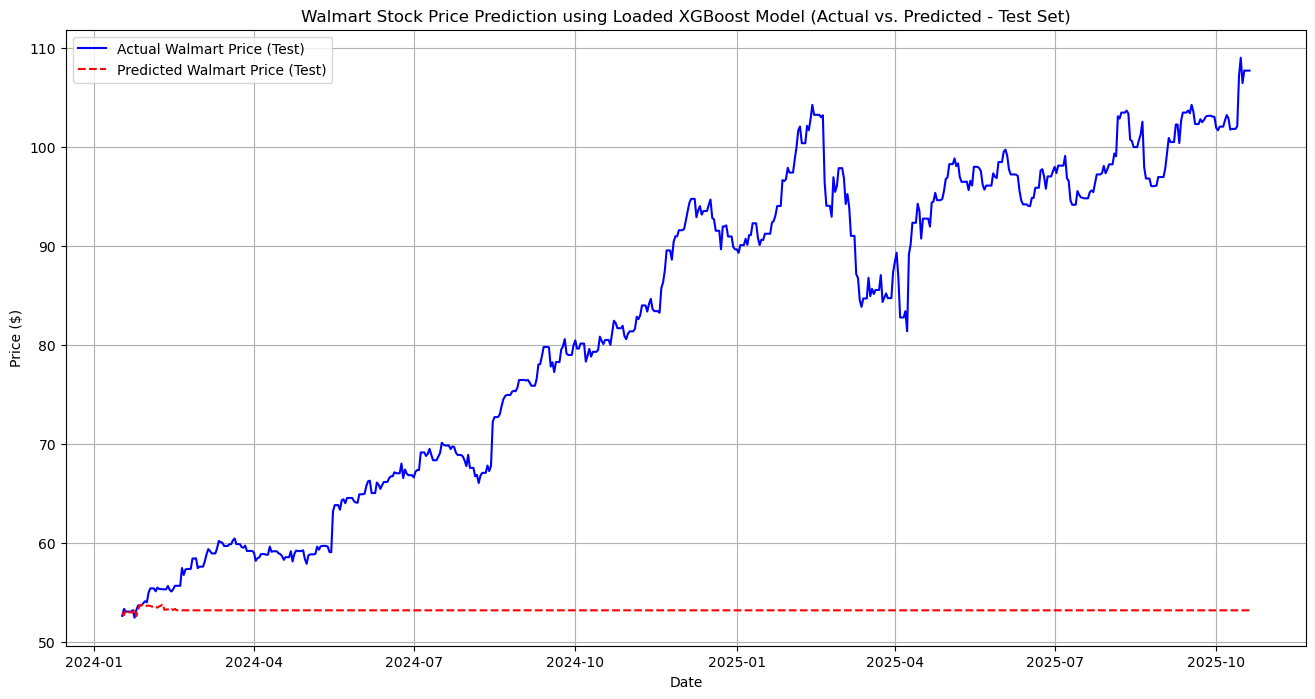


--- XGBoost Prediction Complete ---


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

print("--- Making Predictions with Loaded XGBoost Model ---")

# 1. Load the preprocessed data (same as used for training)
df = pd.read_csv('final_data.csv', index_col=0, parse_dates=True)
df = df.loc['2017':] # Filter data from 2017 onwards
df = df[['Walmart', 'S&P500', 'Diluted EPS', 'MA30', 'MA7']]

# 2. Replicate feature engineering (same as used for training)
n_lags_walmart_sp500 = 24 # Lags 1 to 24
n_lags_ma = 1 # Lag 1 for MA30 and MA7

# Create lagged features for Walmart
for i in range(1, n_lags_walmart_sp500 + 1):
    df[f'Walmart_Lag{i}'] = df['Walmart'].shift(i)

# Create lagged features for S&P500
for i in range(1, n_lags_walmart_sp500 + 1):
    df[f'S&P500_Lag{i}'] = df['S&P500'].shift(i)

# Create lagged features for MA30 and MA7
for i in range(1, n_lags_ma + 1):
    df[f'MA30_Lag{i}'] = df['MA30'].shift(i)
    df[f'MA7_Lag{i}'] = df['MA7'].shift(i)

# 3. Define target (y) and features (X)
y = df['Walmart']
# Exclude current day's target, original S&P500, MA30, MA7 to avoid data leakage
X = df.drop(columns=['Walmart', 'S&P500', 'MA30', 'MA7'])

# 4. Handle any remaining missing values in features (same as used for training)
X = X.fillna(method='ffill')
X = X.fillna(method='bfill')

# 5. Align X and y after handling NaNs
df_aligned = pd.concat([X, y], axis=1).dropna()
X_aligned = df_aligned.drop(columns=['Walmart'])
y_aligned = df_aligned['Walmart']

# 6. Re-split data into training and test sets (same split as used for training)
train_size = int(len(X_aligned) * 0.8)
X_test = X_aligned.iloc[train_size:]
y_test = y_aligned.iloc[train_size:]

print(f"Test set size for prediction: {len(X_test)} samples")

# Ensure the loaded_xgboost_model is available from the previous cell
if 'loaded_xgboost_model' in locals():
    # 7. Make predictions on the test set
    y_pred = loaded_xgboost_model.predict(X_test)

    # 8. Evaluate the predictions
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\nPrediction Evaluation on Test Set:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # 9. Visualize the predictions
    plt.figure(figsize=(16, 8))
    plt.plot(y_test.index, y_test, label='Actual Walmart Price (Test)', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Walmart Price (Test)', color='red', linestyle='--')
    plt.title('Walmart Stock Price Prediction using Loaded XGBoost Model (Actual vs. Predicted - Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- XGBoost Prediction Complete ---")
else:
    print("Error: 'loaded_xgboost_model' not found. Please run the cell that loads the XGBoost model first.")
